In [856]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params
import functools
import torch.utils.model_zoo as model_zoo
from typing import Optional, Union, List
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from tqdm import tqdm as tqdm

In [857]:
class Conv2dReLU(nn.Sequential):

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()
        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)
        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class SEModule(nn.Module):

    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.cSE(x)

class sSEModule(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.sSE(x)

class SCSEModule(nn.Module):
 
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class ArgMax(nn.Module):

    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'tanh':
            self.activation = nn.Tanh()
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/tanh/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):

    def __init__(self, name, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == 'scse':
            self.attention = SCSEModule(**params)
        elif name == 'se':
            self.attention = SEModule(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [858]:
class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
            use_batchnorm=True,
            attention_type=None,
    ):
        super().__init__()

        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels,
            n_blocks=5,
            use_batchnorm=True,
            attention_type=None,
            center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        encoder_channels = encoder_channels[1:]  # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[::-1]  # reverse channels to start from head of encoder

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]    # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [859]:
def patch_first_conv(model, in_channels):

    # get first conv
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            break

    # change input channels for first conv
    module.in_channels = in_channels
    weight = module.weight.detach()
    reset = False

    if in_channels == 1:
        weight = weight.sum(1, keepdim=True)
    elif in_channels == 2:
        weight = weight[:, :2] * (3.0 / 2.0)
    else:
        reset = True
        weight = torch.Tensor(
            module.out_channels,
            module.in_channels // module.groups,
            *module.kernel_size
        )

    module.weight = nn.parameter.Parameter(weight)
    if reset:
        module.reset_parameters()


def replace_strides_with_dilation(module, dilation_rate):
    """Patch Conv2d modules replacing strides with dilation"""
    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kh // 2) * dilation_rate)

            # Kostyl for EfficientNet
            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()

In [860]:
class EncoderMixin:
    
    @property
    def out_channels(self):
        """Return channels dimensions for each tensor of forward output of encoder"""
        return self._out_channels[: self._depth + 1]

    def set_in_channels(self, in_channels):
        """Change first convolution channels"""
        if in_channels == 3:
            return

        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])

        patch_first_conv(model=self, in_channels=in_channels)

    def get_stages(self):
        """Method should be overridden in encoder"""
        raise NotImplementedError

    def make_dilated(self, stage_list, dilation_list):
        stages = self.get_stages()
        for stage_indx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(
                module=stages[stage_indx],
                dilation_rate=dilation_rate,
            )

In [861]:
class EfficientNetEncoder(EfficientNet, EncoderMixin):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)


def  _get_pretrained_settings(encoder):
    pretrained_settings = {
        "imagenet": {
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
            "url": url_map[encoder],
            "input_space": "RGB",
            "input_range": [0, 1],
        },
        "advprop": {
            "mean": [0.5, 0.5, 0.5],
            "std": [0.5, 0.5, 0.5],
            "url": url_map_advprop[encoder],
            "input_space": "RGB",
            "input_range": [0, 1],
        }
    }
    return pretrained_settings


efficient_net_encoders = {
    "efficientnet-b0": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b0"),
        "params": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (3, 5, 9, 16),
            "model_name": "efficientnet-b0",
        },
    },
    "efficientnet-b1": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b1"),
        "params": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (5, 8, 16, 23),
            "model_name": "efficientnet-b1",
        },
    },
    "efficientnet-b2": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b2"),
        "params": {
            "out_channels": (3, 32, 24, 48, 120, 352),
            "stage_idxs": (5, 8, 16, 23),
            "model_name": "efficientnet-b2",
        },
    },
    "efficientnet-b3": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b3"),
        "params": {
            "out_channels": (3, 40, 32, 48, 136, 384),
            "stage_idxs": (5, 8, 18, 26),
            "model_name": "efficientnet-b3",
        },
    },
    "efficientnet-b4": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b4"),
        "params": {
            "out_channels": (3, 48, 32, 56, 160, 448),
            "stage_idxs": (6, 10, 22, 32),
            "model_name": "efficientnet-b4",
        },
    },
    "efficientnet-b5": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b5"),
        "params": {
            "out_channels": (3, 48, 40, 64, 176, 512),
            "stage_idxs": (8, 13, 27, 39),
            "model_name": "efficientnet-b5",
        },
    },
    "efficientnet-b6": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b6"),
        "params": {
            "out_channels": (3, 56, 40, 72, 200, 576),
            "stage_idxs": (9, 15, 31, 45),
            "model_name": "efficientnet-b6",
        },
    },
    "efficientnet-b7": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b7"),
        "params": {
            "out_channels": (3, 64, 48, 80, 224, 640),
            "stage_idxs": (11, 18, 38, 55),
            "model_name": "efficientnet-b7",
        },
    },
}

In [862]:
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

In [863]:
def get_encoder(name, in_channels=3, depth=5, weights=None):

    try:
        Encoder = encoders[name]["encoder"]
    except KeyError:
        raise KeyError("Wrong encoder name `{}`, supported encoders: {}".format(name, list(encoders.keys())))

    params = encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights is not None:
        try:
            settings = encoders[name]["pretrained_settings"][weights]
        except KeyError:
            raise KeyError("Wrong pretrained weights `{}` for encoder `{}`. Available options are: {}".format(
                weights, name, list(encoders[name]["pretrained_settings"].keys()),
            ))
        encoder.load_state_dict(model_zoo.load_url(settings["url"]))

    encoder.set_in_channels(in_channels)

    return encoder


def get_encoder_names():
    return list(encoders.keys())

def get_preprocessing_params(encoder_name, pretrained="imagenet"):
    settings = encoders[encoder_name]["pretrained_settings"]

    if pretrained not in settings.keys():
        raise ValueError("Available pretrained options {}".format(settings.keys()))

    formatted_settings = {}
    formatted_settings["input_space"] = settings[pretrained].get("input_space")
    formatted_settings["input_range"] = settings[pretrained].get("input_range")
    formatted_settings["mean"] = settings[pretrained].get("mean")
    formatted_settings["std"] = settings[pretrained].get("std")
    return formatted_settings


def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained=pretrained)
    return functools.partial(preprocess_input, **params)

In [864]:
class SegmentationModel(torch.nn.Module):
    
    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    def predict(self, x):
   
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)

        return x

In [865]:
class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)


class ClassificationHead(nn.Sequential):

    def __init__(self, in_channels, classes, pooling="avg", dropout=0.2, activation=None):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        flatten = Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = Activation(activation)
        super().__init__(pool, flatten, dropout, linear, activation)

In [866]:
class Unet(SegmentationModel):

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [867]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='binary')
    plt.show()

In [868]:
encoders = {}
encoders.update(efficient_net_encoders)
DEVICE='cpu'
ENCODER = "efficientnet-b5"
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [869]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

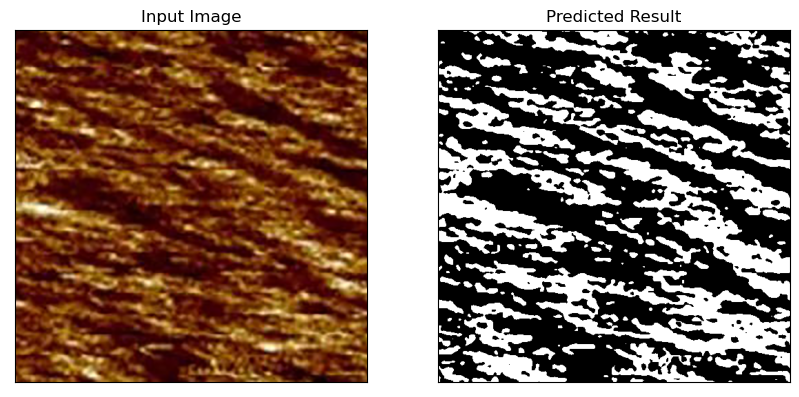

In [870]:
best_model = torch.load('C:/Users/Brian/Desktop/PesU-Net/best_model.pth',map_location='cpu')
test=cv2.imread('C:/Users/Brian/Desktop/test.PNG')
#test=cv2.resize(test,(512,512))
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
input_process=get_preprocessing(preprocessing_fn)
sample = input_process(image=test)
image= sample['image']
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_label = best_model.predict(x_tensor)
pr_label = (pr_label.squeeze().cpu().numpy().round())
visualize(
    input_image=test, 
    predicted_result=pr_label
)